Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt

jupyter_black.load()

## Context
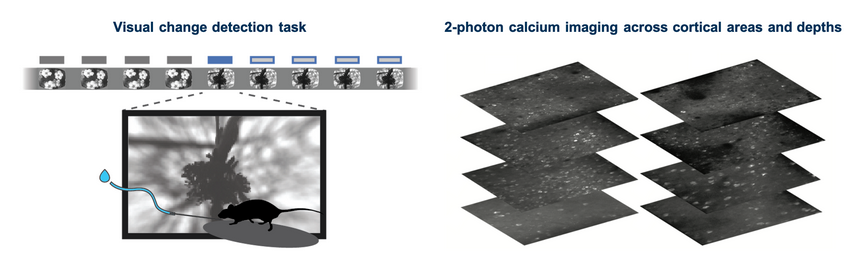

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

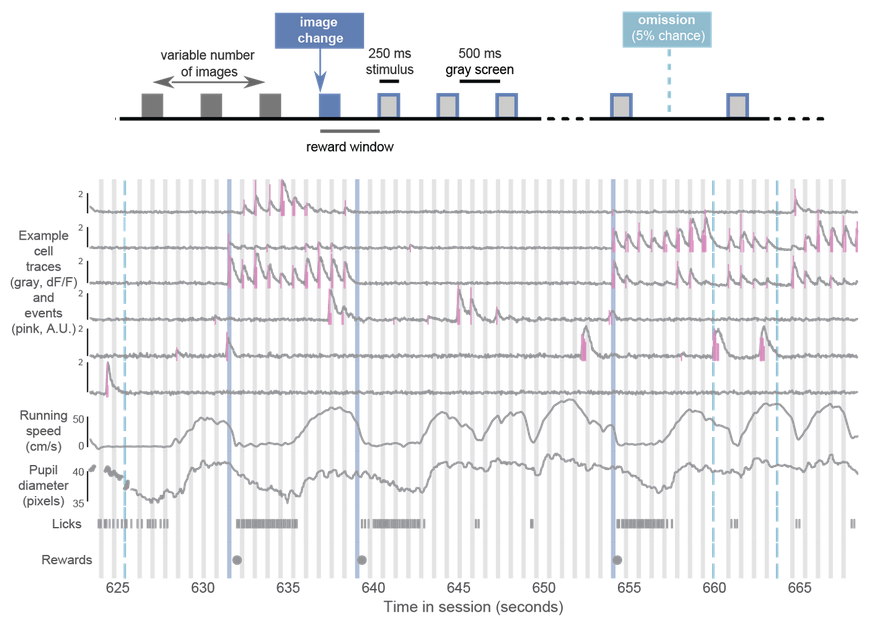

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path="../data/")
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
#
print(data["stim_epoch_table"])
print(data["stim_table"])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
0                   1.0        225.0          0.0     747.0     807.0
1               

# Data Exploration 
* Display the maximum projection of the ROIs.
* Display the roi masks.

* Display the df/f traces over time maby normalized to the maximum value of the trace.
    * Visualize the traces where the drifting gratings were shown.


## 3. Display the maximum projection of the ROIs, and the roi masks

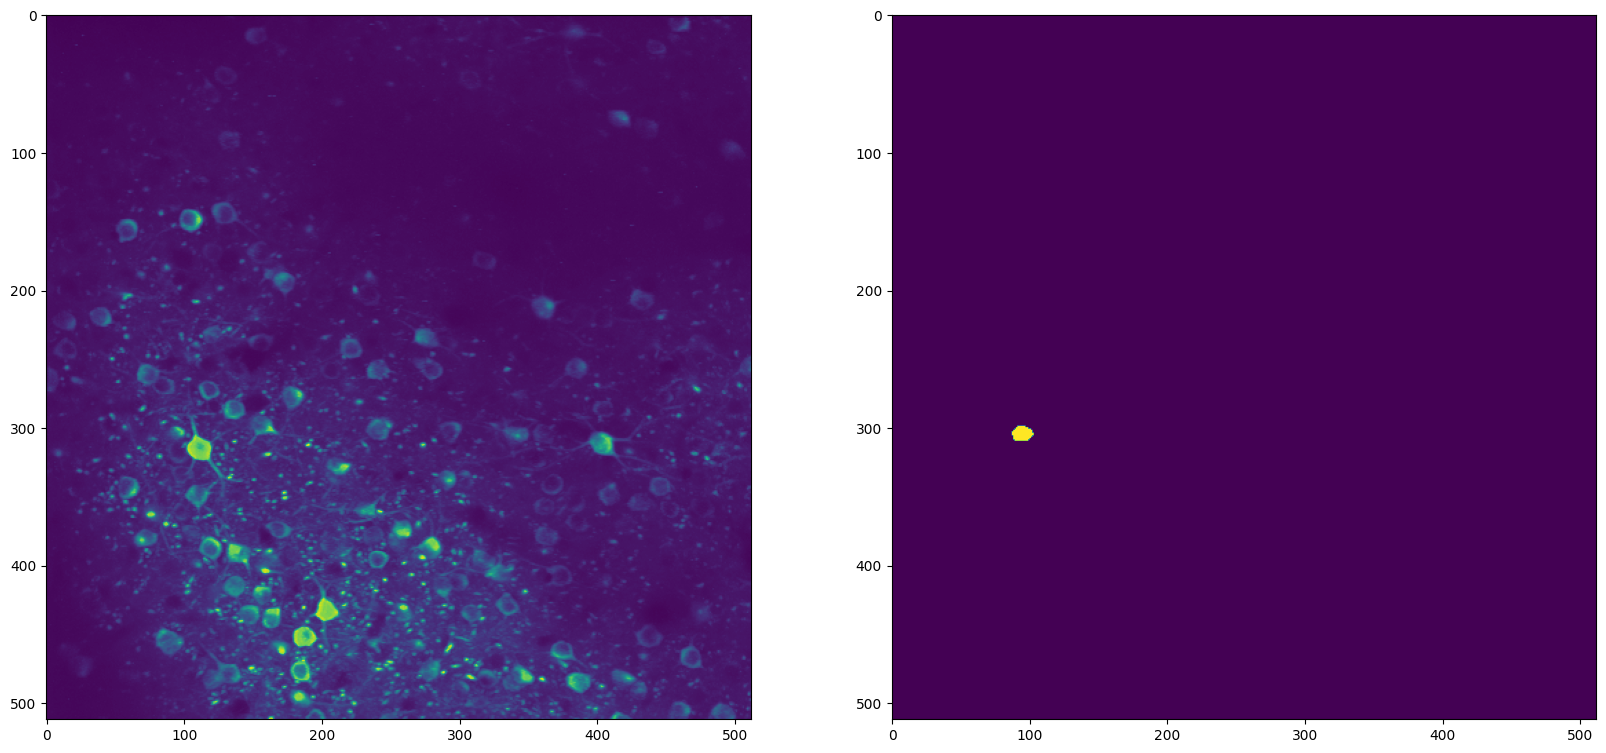

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["roi_masks"][0, :, :])

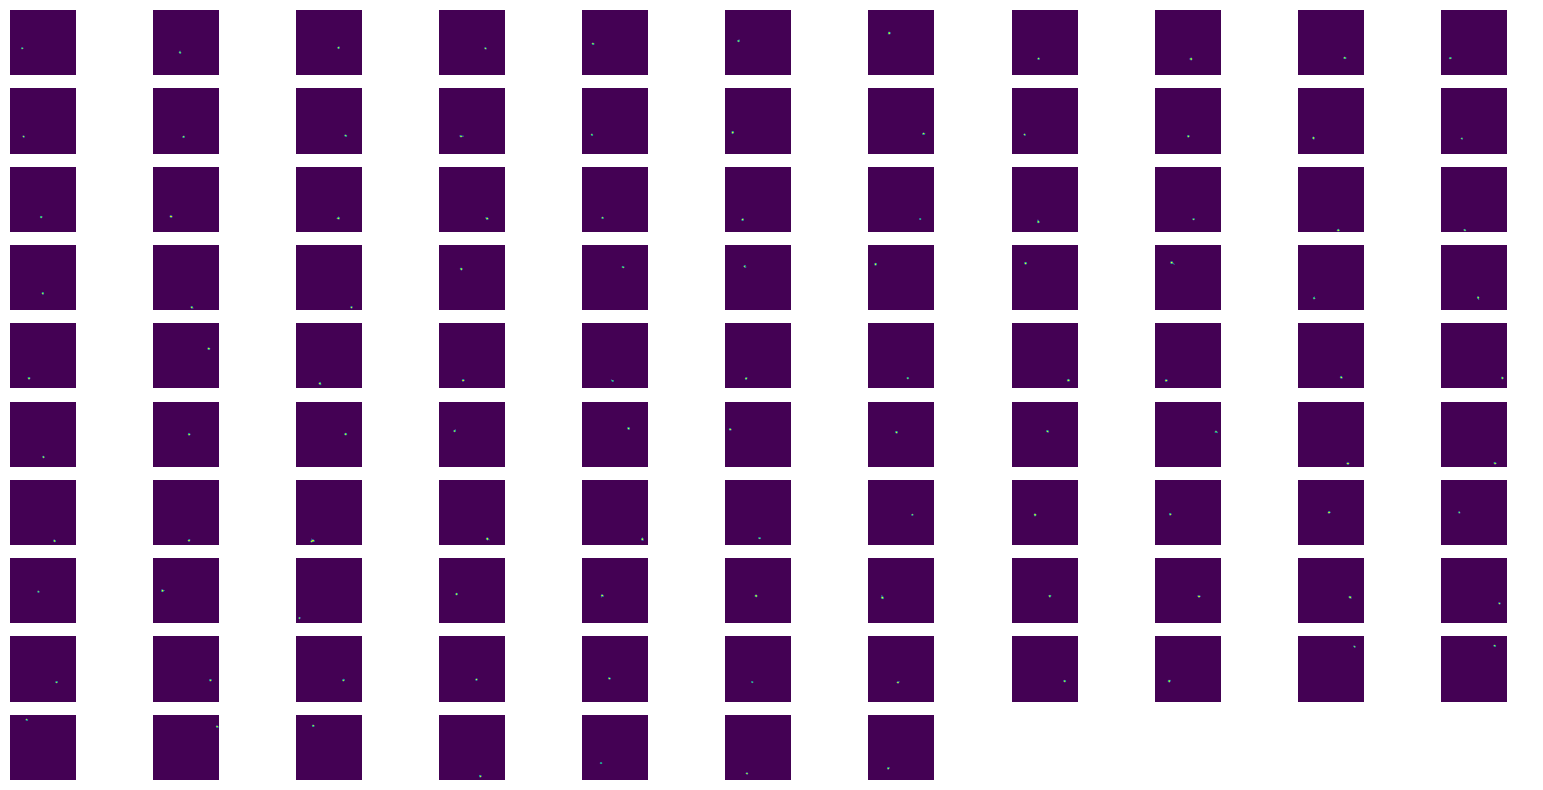

In [4]:
fig, axs = plt.subplots(10, 11, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    if i < 106:
        ax.imshow(data["roi_masks"][i, :, :])
    ax.axis("off")
plt.show()

## 4. The trials are not equally distributed with orientation 
* but over all trials we have aroung 75 trials for each orientation and 30 trials for the blank stimulus

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [75 75 75 74 75 75 75 74 30]
[ 1.  2.  4.  8. 15. nan] [120 120 119 120 119  30]
[0. 1.] [598  30]


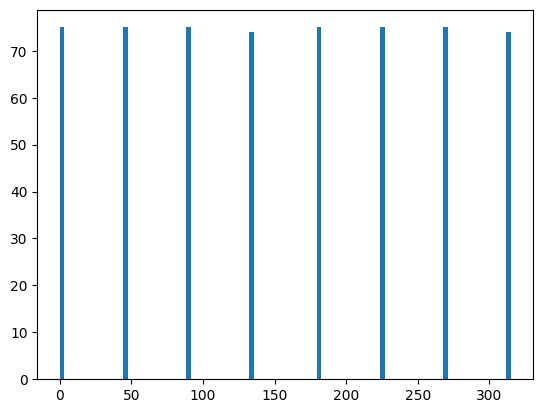

In [5]:
# dataframe where only the drifting gratings are shown
# data_drifting_stimulus = data["stim_table"][
#     data["stim_epoch_table"]["stimulus"] == "drifting_gratings"
# ]

plt.hist(data["stim_table"]["orientation"], bins=100)
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(uniq, coutnts)
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(freqs, counts_freqs)
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(blanks, counts_blanks)

In [6]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(uniq, coutnts)

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(uniq, coutnts)

[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 25 22 25 24 29 18 19 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [23 26 19 22 21 22 28 27 12]
[  0.  45.  90. 135. 180. 225. 270. 315.  nan] [26 24 34 27 29 24 29 28  6]


## 1. First look at all the calcium traces 
There are 106 different ROIs and to plot them nicely on top of each other we normalize them to the maximum value of the trace.

Text(0.5, 0.98, 'dF/F traces for all ROIs')

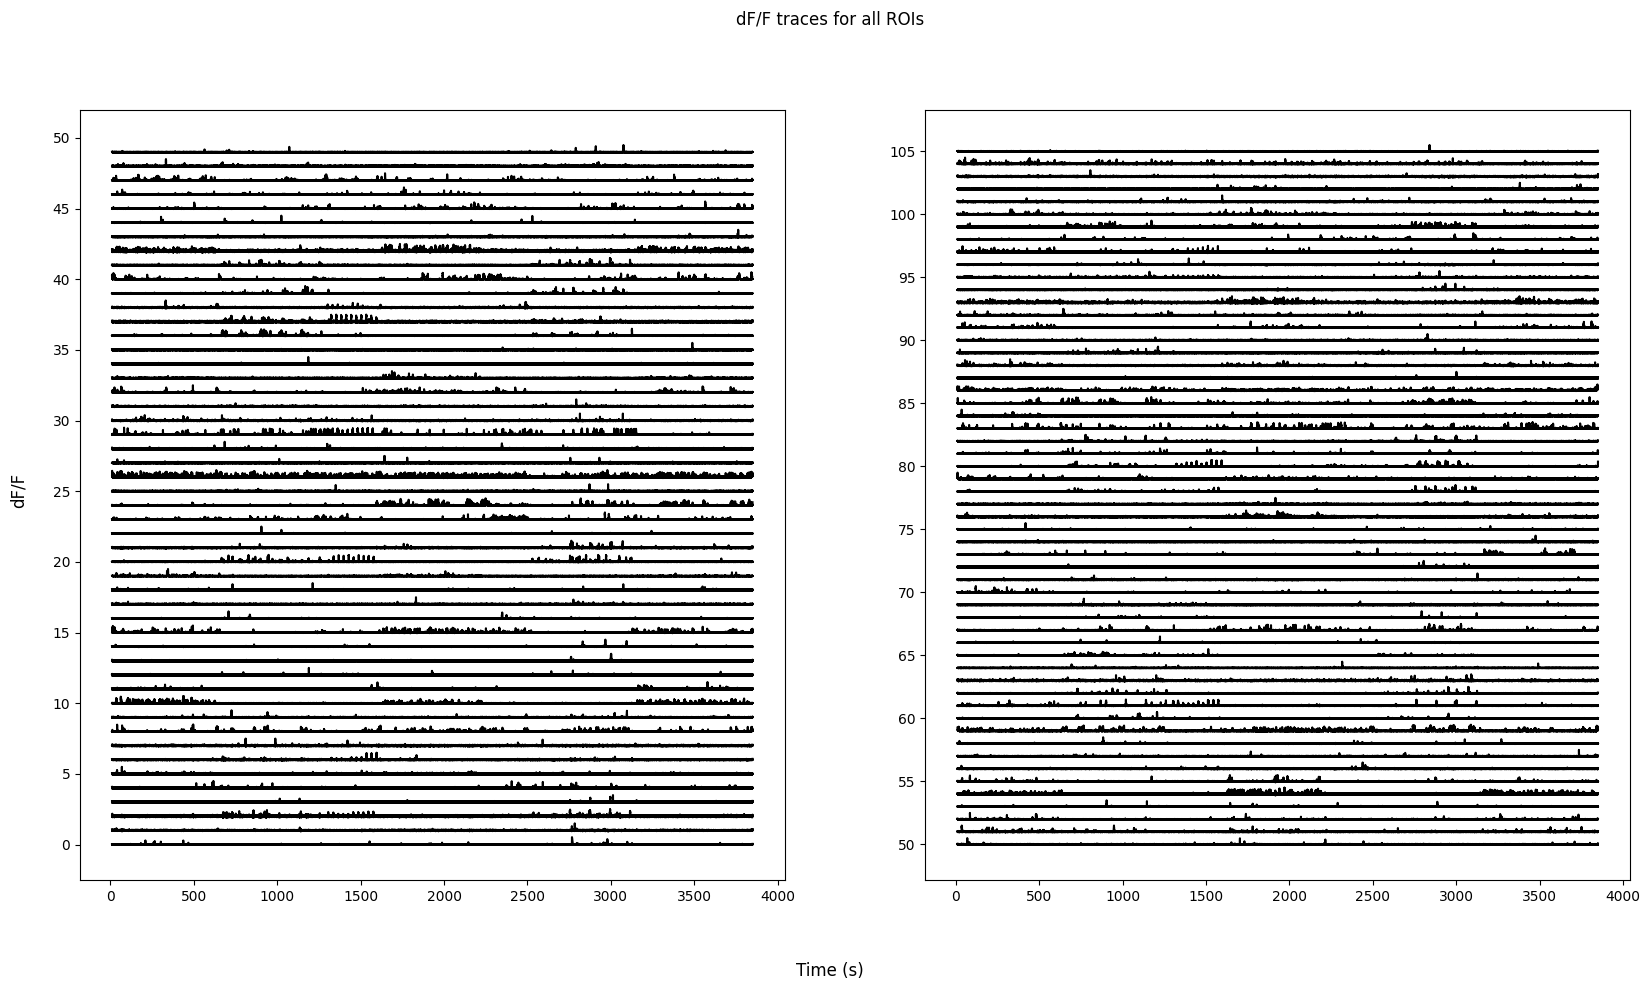

In [7]:
# plot dff traces into to subplots with the normalized dff values
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
fig.suptitle(
    "dF/F traces for all ROIs",
)

## 2. Visualize the traces where the drifting gratings were shown
For this we used the start and stop times in the stim_epoch_table. The added vertical lines indicate the start and stop times of the drifting gratings.

In [8]:
# get the start and end times of the drifting grating stimulus
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)
print(data["t"][np.array(start_times)])
print(data["t"][np.array(end_times)])
print(data["t"][np.array(end_times)] - data["t"][np.array(start_times)])
print(
    data["t"][data["stim_table"]["end"][0].astype(int)]
    - data["t"][data["stim_table"]["start"][0].astype(int)]
)

[  34.51795 1625.90436 3157.53702]
[ 634.02188 2225.4245  3841.13976]
[599.50393 599.52014 683.60274]
1.9952200000000033


Text(0.09, 0.5, 'dF/F')

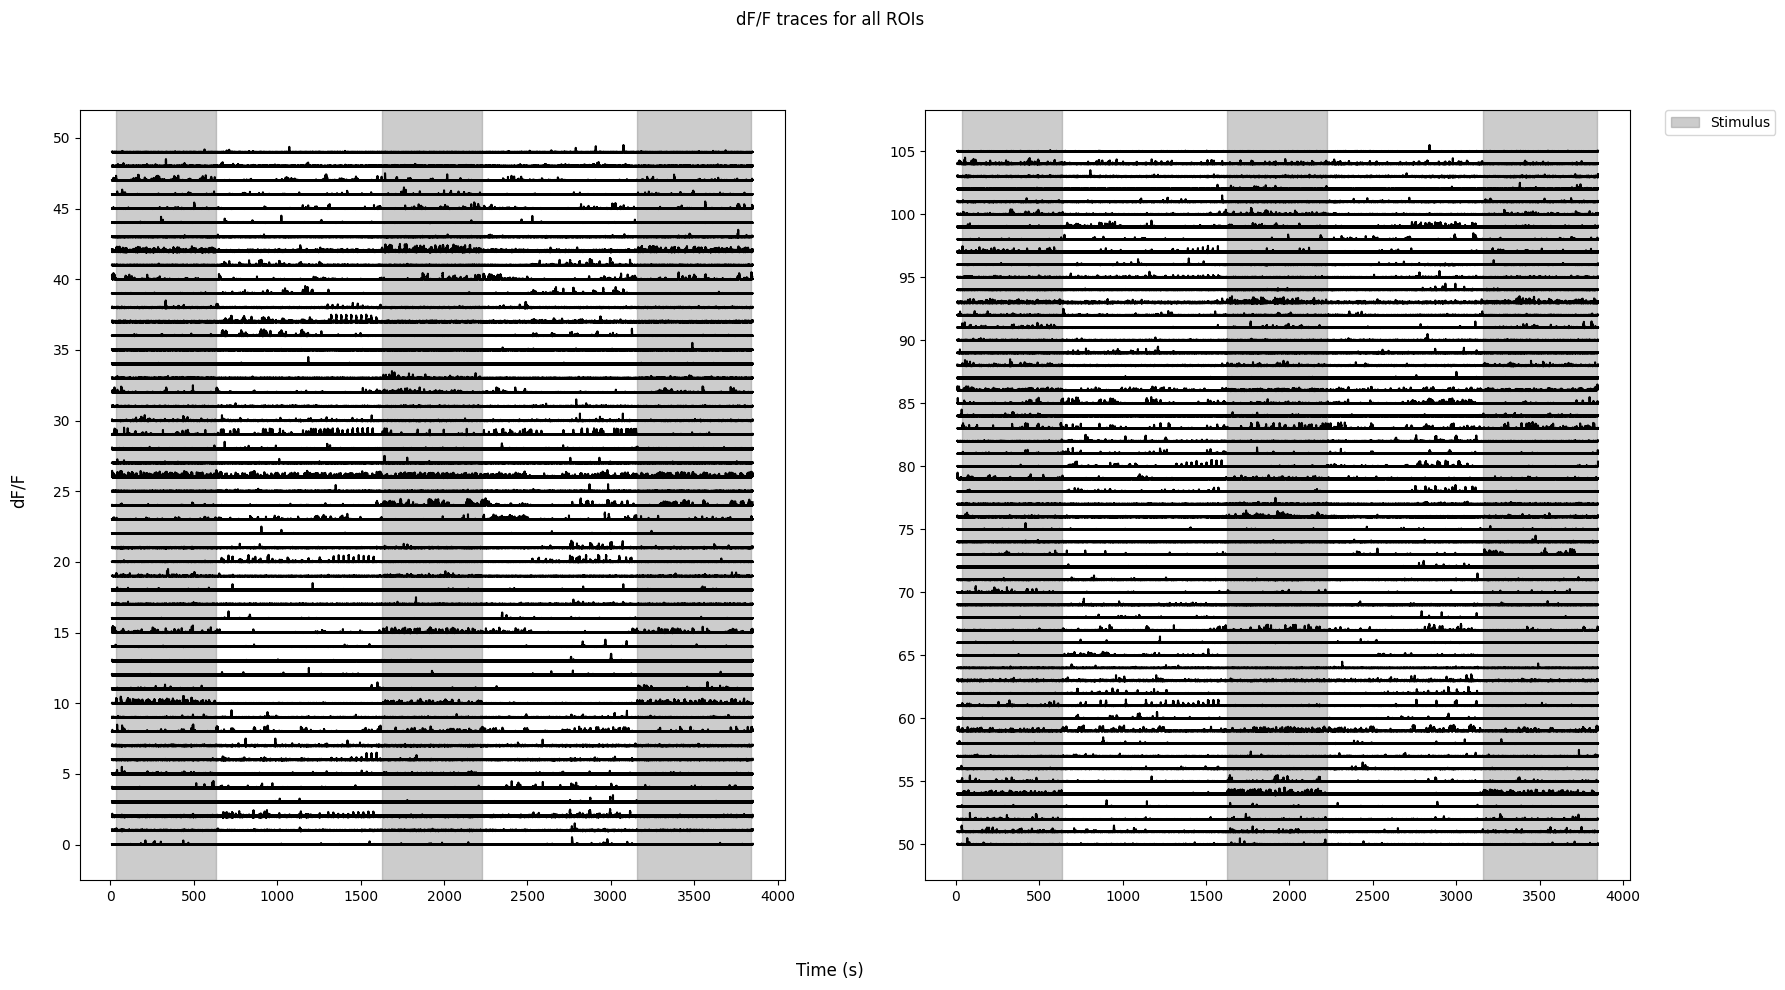

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
# plot the start and end times of the stimulus as gray areas
for i, s in enumerate(start_times):
    axs[0].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")
    if i == 0:
        axs[1].axvspan(
            data["t"][s],
            data["t"][end_times[i]],
            alpha=0.4,
            color="gray",
            label="Stimulus",
        )
    else:
        axs[1].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
axs[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
fig.suptitle(
    "dF/F traces for all ROIs",
)
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

## Looking at some promissing cells, plotting the first trial:
* 15, 42, 54; because they show high activity during the drifting gratings in all 3 trials
* we can estimate that cell 42 is selective to orientation 0° and 180°
* cell 54 is selectivwe to orientation to 135° and 315° ? 

In [33]:
colors_list = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
    "#ffc107",
    "#ff9800",
    "#f44336",
    "#ad1457",
    "k",
]

orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

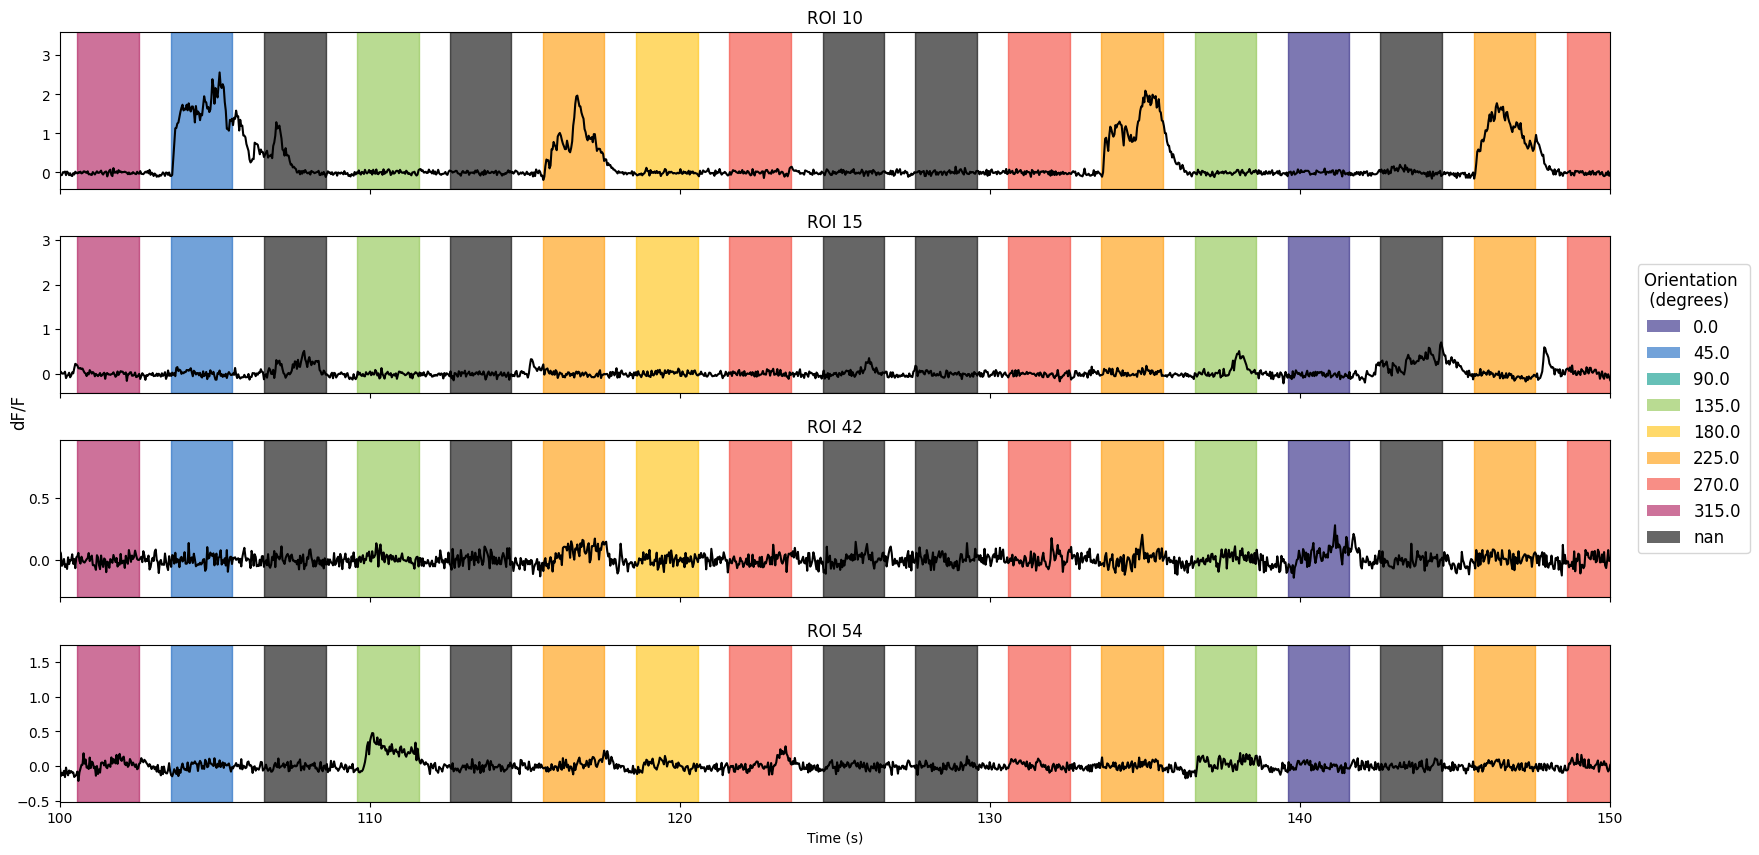

In [11]:
import matplotlib.patches as mp

rois = [10, 15, 42, 54]
fig, axs = plt.subplots(len(rois), figsize=(20, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [100, 150]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
axs[i].set_xlabel("Time (s)")
fig.supylabel("dF/F", x=0.1, y=0.5)

axs[i].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(1.05, 2.5),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation \n (degrees)",
    title_fontsize=12,
)

## 5. Can we already see orientation selectivity in the traces?

In [12]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
mean_calcium_orientation_baseline = np.zeros((data["dff"].shape[0], len(orientations)))
std_calcium_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_calcium_orientation_baseline = np.zeros((data["dff"].shape[0], len(orientations)))
for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    start_times_bs = (
        data["stim_table"]["start"][data["stim_table"]["blank_sweep"] == 1]
        .to_numpy()
        .astype(int)
    )

    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times_bs = (
        data["stim_table"]["end"][data["stim_table"]["blank_sweep"] == 1]
        .to_numpy()
        .astype(int)
    )

    for roi in range(data["dff"].shape[0]):
        mean_calcium_orientation[roi, i] = np.mean(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        mean_calcium_orientation_baseline[roi, i] = np.mean(
            [
                np.mean(data["dff"][roi, s:e])
                for s, e in zip(start_times_bs, end_times_bs)
            ],
            axis=0,
        )
        std_calcium_orientation[roi, i] = np.std(
            [np.mean(data["dff"][roi, s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_calcium_orientation_baseline[roi, i] = np.std(
            [
                np.mean(data["dff"][roi, s:e])
                for s, e in zip(start_times_bs, end_times_bs)
            ],
            axis=0,
        )
print(mean_calcium_orientation.shape)

(106, 8)


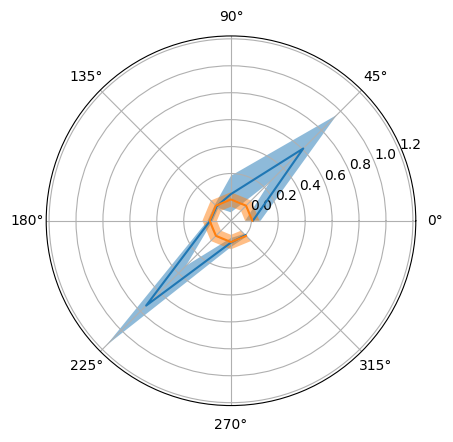

In [13]:
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[10, :],
)
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[10, :] - std_calcium_orientation[10, :],
    mean_calcium_orientation[10, :] + std_calcium_orientation[10, :],
    alpha=0.5,
)
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation_baseline[10, :],
)
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation_baseline[10, :] - std_calcium_orientation_baseline[10, :],
    mean_calcium_orientation_baseline[10, :] + std_calcium_orientation_baseline[10, :],
    alpha=0.5,
)

# Is the temporal resolution interfering with the orientation selectivity?

In [14]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_calcium_orientation = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_calcium_orientation[roi, i, j] = np.mean(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
            std_calcium_orientation[roi, i, j] = np.std(
                [
                    np.mean(data["dff"][roi, s:e])
                    for s, e in zip(start_times, end_times)
                ],
                axis=0,
            )
print(mean_calcium_orientation.shape)

(106, 8, 5)


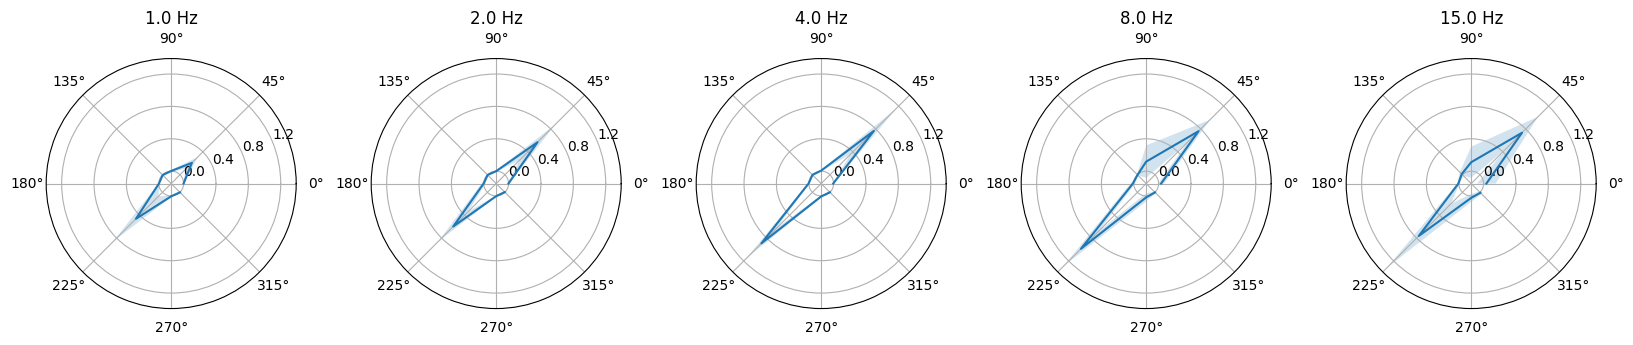

In [15]:
# plot a polar plot for for each orientation and temporal frequency
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_calcium_orientation[10, :, i] - std_calcium_orientation[10, :, i],
        mean_calcium_orientation[10, :, i] + std_calcium_orientation[10, :, i],
        alpha=0.2,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")
    ax.set_yticks(np.arange(0, 1.5, 0.4))

# Transforming the calcium traces to spikes
* only transform the traces where the drifting gratings were shown
* use the algorithm from coding lab 3 the OASIS algorithm, or trying out py-oopsi

In [16]:
import oopsi as ops
import os

# check if spike data is already saved
if os.path.exists("../data/spike_data.npy"):
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        print(n.shape)
        print(roi)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

In [17]:
# thershold the spike data at get the time points where the spike occurs
spike_data[spike_data < 0.2] = 0
spike_data[spike_data >= 0.2] = 1
spike_data = spike_data.astype(int)
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] >= 0.5])
spike_times = np.array(spike_times, dtype=object)
# plot the spike times, the calcium trace and the deconvolved calcium trace
print(spike_times)

[array([ 209.63294,  258.68259,  265.73244,  302.41164,  436.7581 ,
        1262.99587, 1553.67499, 1553.70825, 1743.29389, 2145.61231,
        2766.15416, 2766.51997, 2766.55322, 2766.58648, 2767.0188 ,
        2767.08531, 2884.67622, 2968.74585, 2977.49202, 2977.7248 ,
        2977.85783, 2978.98851, 2979.02177, 3126.94198, 3655.40646])
 array([  35.4823 ,   35.61532,   35.64857,  112.63117,  190.61166,
         644.23093,  700.66339, 1135.26511, 1139.92074, 1141.58347,
        1273.20503, 1883.03094, 2358.87729, 2766.32044, 2766.38695,
        2766.4202 , 2767.51763, 2783.34717, 2783.71298, 2783.74623,
        2795.21932, 2963.29196, 2967.11633, 3155.74122, 3849.61999])
 array([  11.30685,   68.40355,   82.70269,  439.61795,  495.91719,
         641.77011,  675.95548,  675.98873,  676.05524,  685.96501,
         686.16453,  694.74413,  697.43773,  697.50424,  697.53749,
         704.35462,  711.70381,  721.54708,  727.0673 ,  729.32859,
         729.36184,  729.4616 ,  729.89391,  7

(0.0, 100.0)

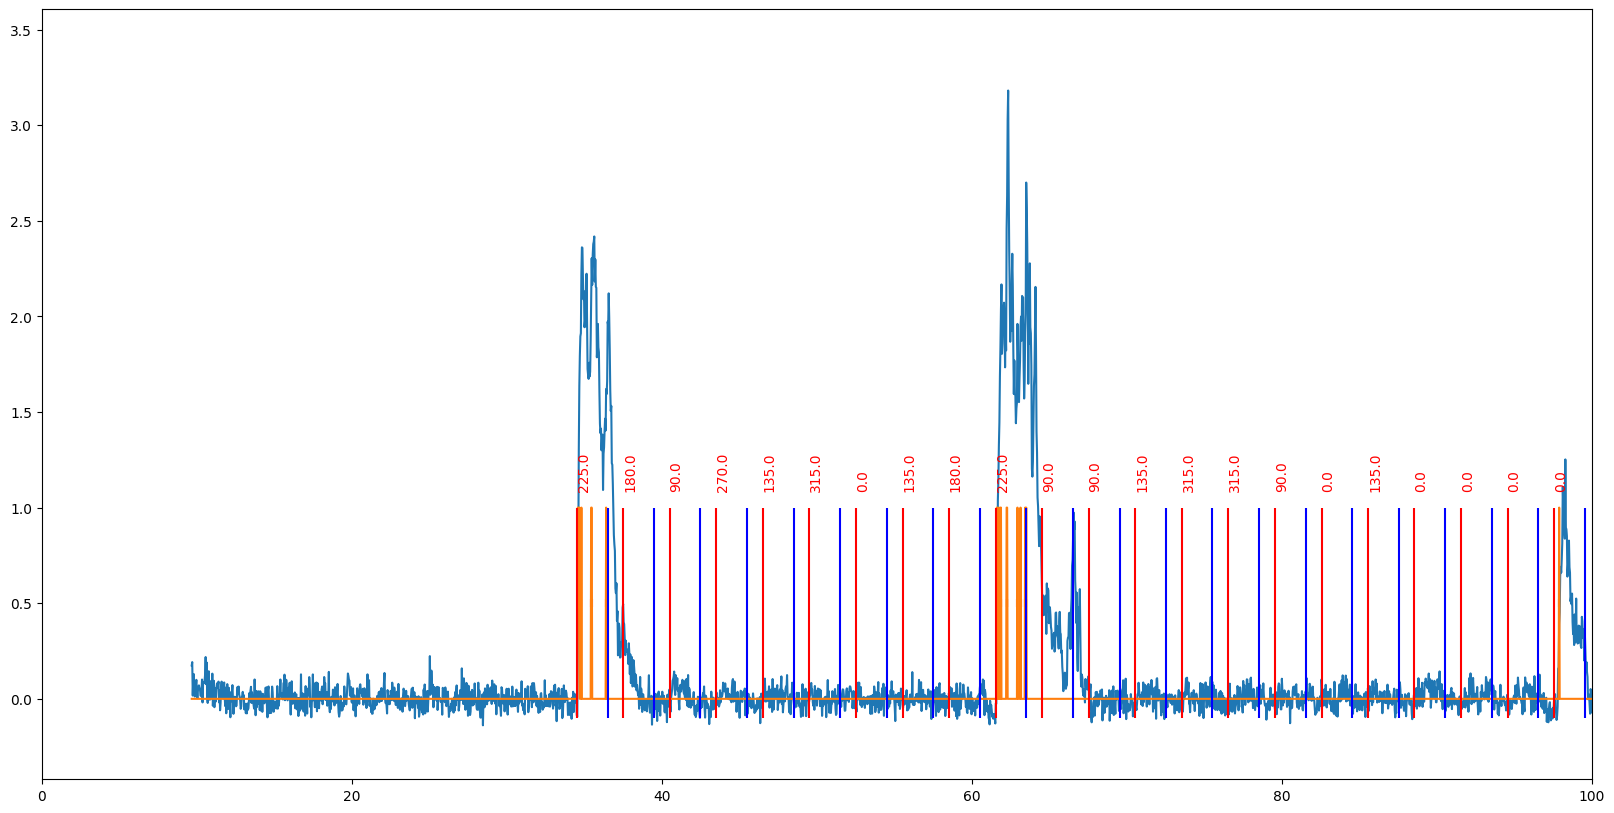

In [18]:
### Sanity check ###
fig, axs = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
axs.plot(data["t"], data["dff"][10, :])
axs.plot(data["t"], spike_data[10, :])
axs.scatter(spike_times[10], np.ones(len(spike_times[10])) * 0.5, c="r", marker="|")
spike_times[0]
for j in data["t"][
    np.array(
        data["stim_table"]["start"],
        dtype=int,
    )
]:
    axs.vlines(j, -0.1, 1, color="r")

for j in data["t"][np.array(data["stim_table"]["end"], dtype=int)]:
    axs.vlines(j, -0.1, 1, color="b")


for indx, j in enumerate(
    data["t"][
        np.array(
            data["stim_table"]["start"],
            dtype=int,
        )
    ]
):
    axs.text(
        j,
        1.1,
        f"{data['stim_table']['orientation'][indx]}",
        color="r",
        rotation=90,
        clip_on=True,
    )
axs.set_xlim(0, 100)

In [19]:
print(spike_data[10, :].shape)

(115471,)


In [20]:
# mean calcium value for each orientation
# get the spike times for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))

for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    for roi in range(data["dff"].shape[0]):
        mean_spike_orientation[roi, i] = np.mean(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_spike_orientation[roi, i] = np.std(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )

In [21]:
print(mean_spike_orientation[10, :])

[0.01333333 1.65333333 0.10666667 0.         0.         2.34666667
 0.         0.        ]


Text(0.5, 1.0, 'ROI 10')

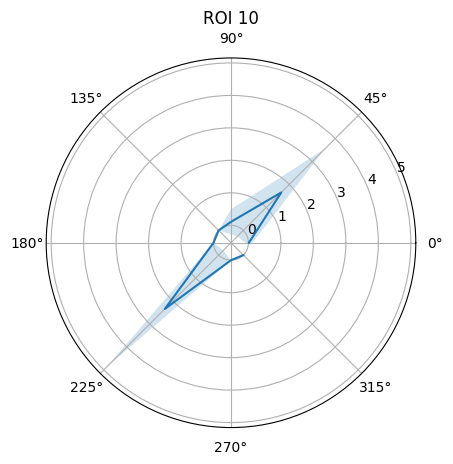

In [22]:
# plot a polar plot for for each orientation
roi = 10
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :],
)
# add std to the plot
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :] - std_spike_orientation[roi, :],
    mean_spike_orientation[roi, :] + std_spike_orientation[roi, :],
    alpha=0.2,
)
ax.set_title(f"ROI {roi}")

In [31]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_spike_orientation_freq[roi, i, j] = np.mean(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )
            std_spike_orientation_freq[roi, i, j] = np.std(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )

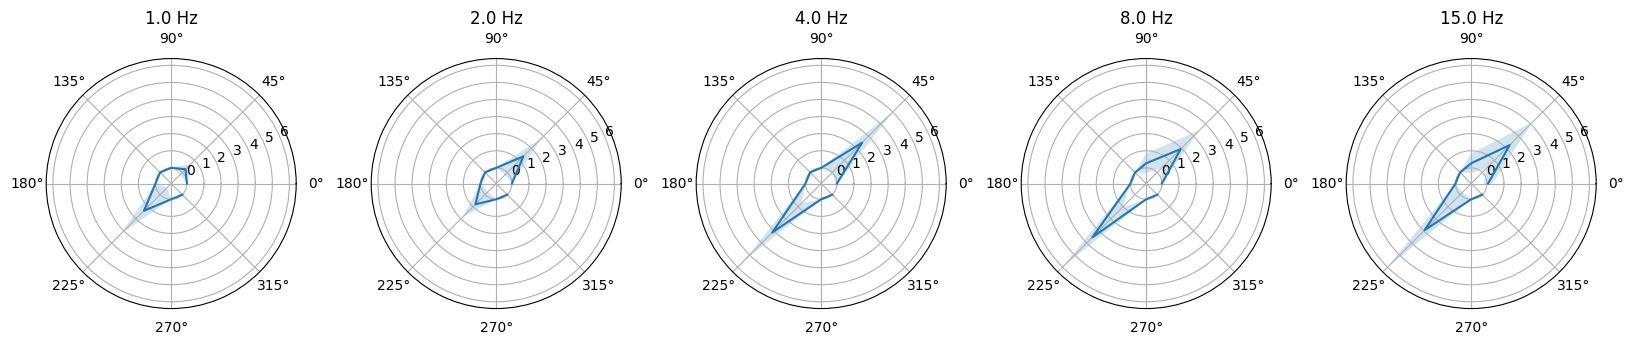

In [24]:
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[10, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[10, :, i] - std_spike_orientation_freq[10, :, i],
        mean_spike_orientation_freq[10, :, i] + std_spike_orientation_freq[10, :, i],
        alpha=0.2,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")

In [25]:
import utils_project1 as utils

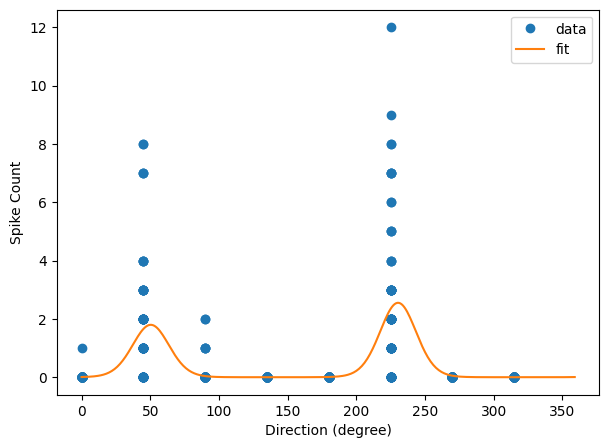

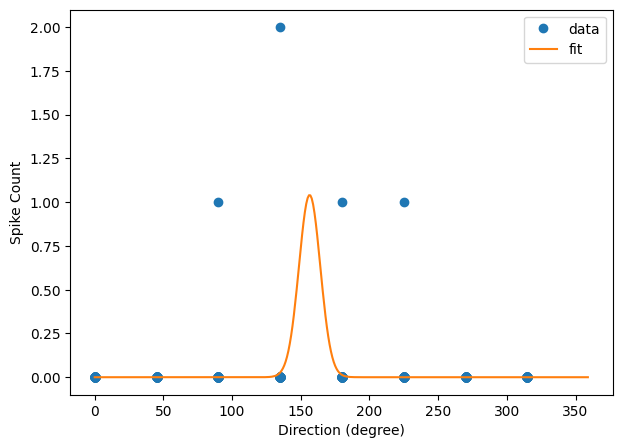

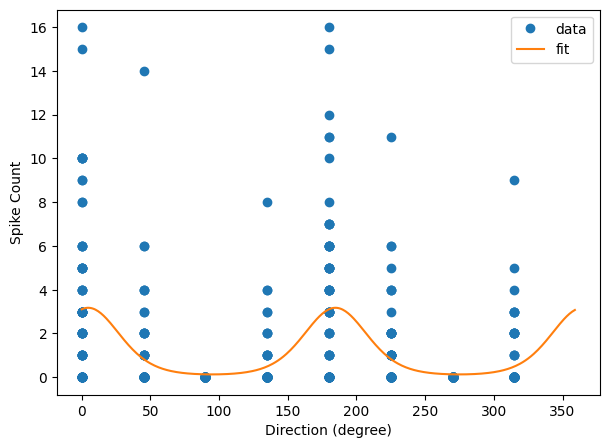

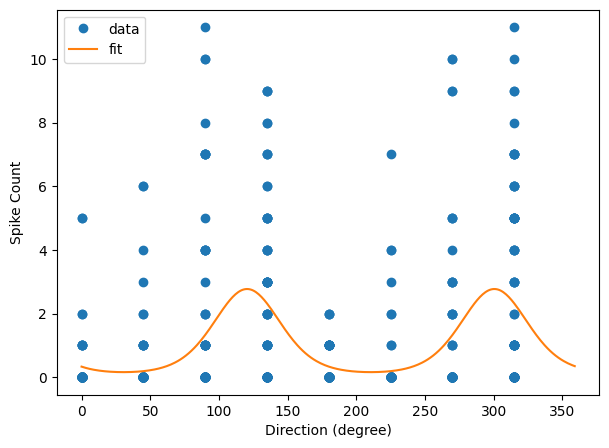

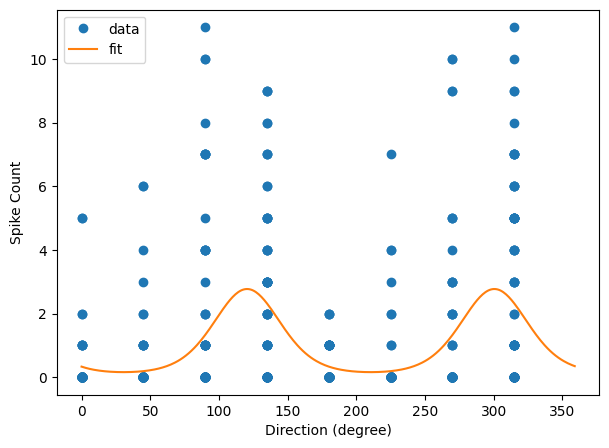

In [26]:
for roi in rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.tuningCurve(counts, dirs, show=True)


utils.tuningCurve(counts, dirs, show=True)

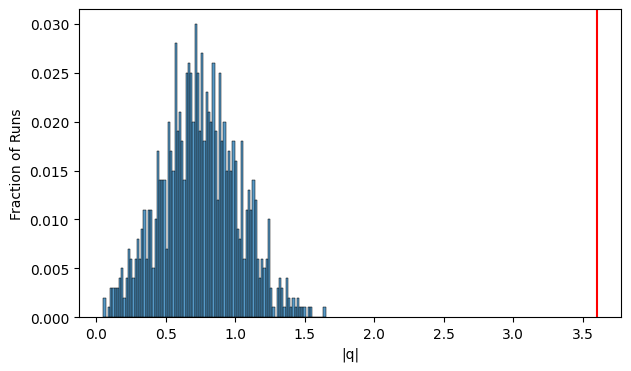

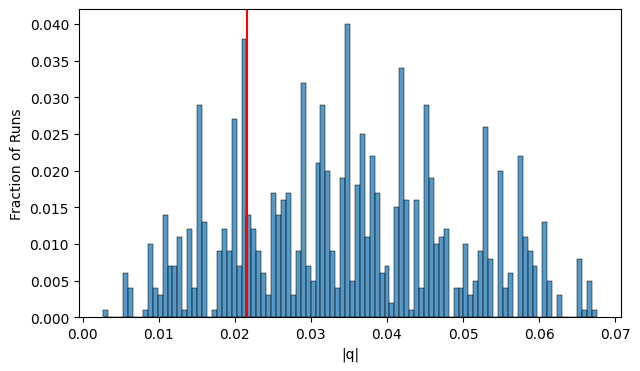

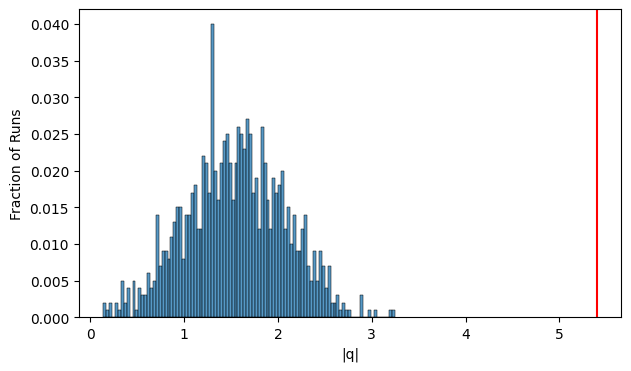

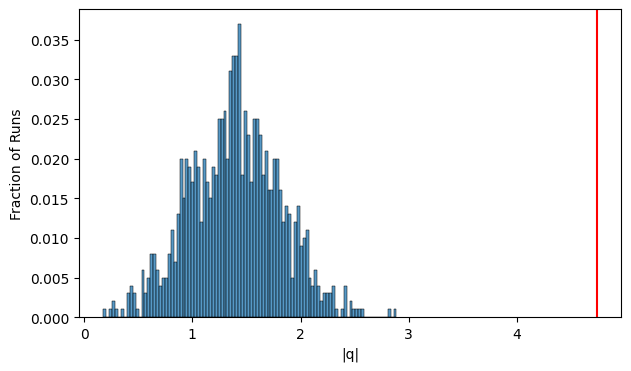

In [27]:
for roi in rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.testTuning(counts, dirs, psi=1, niters=1000, show=True)

In [29]:
p_dirs = np.zeros(data["dff"].shape[0])
for roi in range(data["dff"].shape[0]):
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    p_dirs[roi], _, _ = utils.testTuning(counts, dirs, psi=1, niters=1000, show=False)

print(np.sum(p_dirs < 0.01))
idx = np.where(p_dirs < 0.01)[0]
print(idx)


47
[  6   9  10  11  13  16  18  19  21  22  25  29  31  33  34  37  38  40
  42  46  48  50  51  53  54  55  56  60  62  68  69  70  72  73  77  78
  80  82  84  87  89  91  93  97 100 102 105]


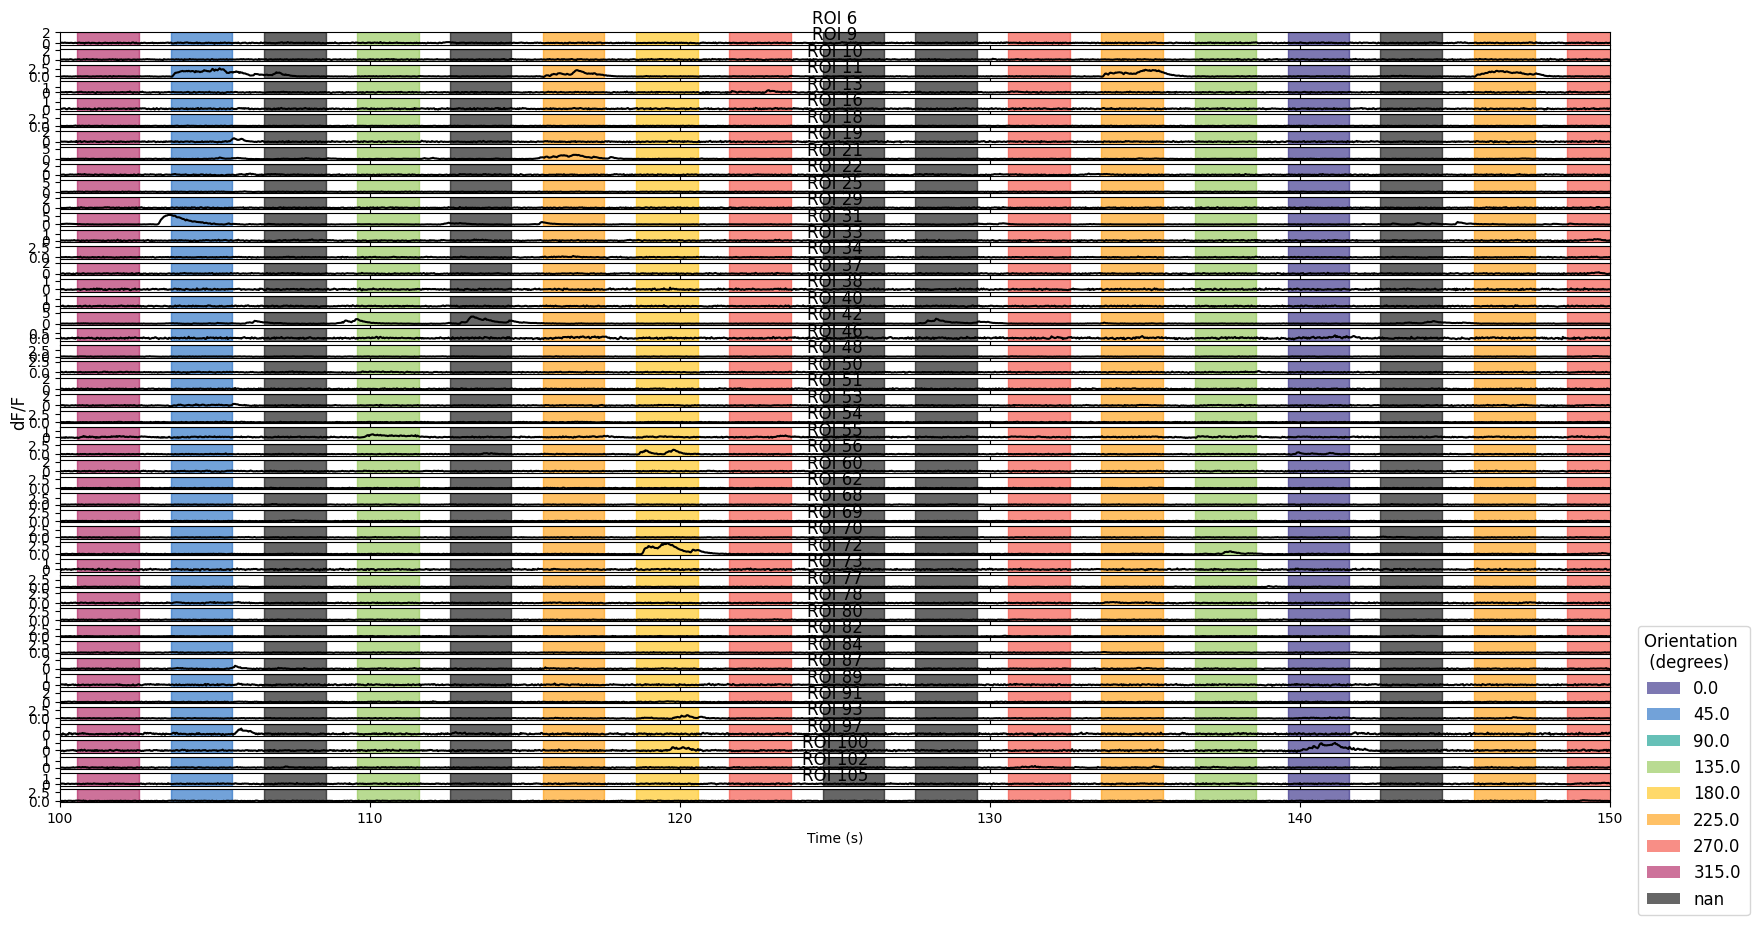

In [34]:
rois = idx
fig, axs = plt.subplots(len(rois), figsize=(20, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [100, 150]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
axs[i].set_xlabel("Time (s)")
fig.supylabel("dF/F", x=0.1, y=0.5)

axs[i].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(1.05, 2.5),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation \n (degrees)",
    title_fontsize=12,
)

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 
5. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.